# 环境设置

In [1]:
import os
import random
import paddle 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2

# 输出Paddle版本
print(paddle.__version__)


2.3.2


# 2. 数据集

In [2]:
import paddle
import os
from os.path import join as pjoin

class MyDateset(paddle.io.Dataset):
    def __init__(self, root_dir = '/jinx/AIStudio/Beautifying/train_datasets'):
        super(MyDateset, self).__init__()

        self.root_dir = root_dir
        # 要根据mask生成img
        self.img_dir = pjoin(root_dir, 'groundtruth')  # 没痘痘的 
        self.mask_dir = pjoin(root_dir, 'image')  # 有痘痘的
        self.file_list = os.listdir(self.img_dir)

    def __getitem__(self, index):

        img_path = pjoin(self.img_dir, self.file_list[index])
        mask_path = pjoin(self.mask_dir, self.file_list[index])


        img = cv2.imread(img_path)
        img = cv2.resize(img, (512, 512)) # （宽，高）
        img = img/255
        img = img.transpose([2,0,1])
        img = paddle.to_tensor(img).astype('float32')

        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (512, 512)) # （宽，高）
        mask = mask/255
        mask = mask.transpose([2,0,1])
        mask = paddle.to_tensor(mask).astype('float32')

        return img, mask

    def __len__(self):
        return len(self.file_list)

if 1:
    dataset=MyDateset()

    dataloader = paddle.io.DataLoader(
        dataset,
        batch_size=16,
        shuffle=True,
        drop_last=False)

    for step, data in enumerate(dataloader):
        img, mask = data
        print(step, img.shape, mask.shape)
        break


W0805 16:14:57.437064 95462 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0805 16:14:57.440119 95462 gpu_resources.cc:91] device: 0, cuDNN Version: 8.1.


0 [16, 3, 512, 512] [16, 3, 512, 512]


# 自定义损失函数

In [ ]:

import paddle
import paddle.nn.functional as F


# 定义loss
def gaussian1d(window_size, sigma):
    ###window_size = 11
    x = paddle.arange(window_size, dtype="float32")
    x = x - window_size // 2
    gauss = paddle.exp(-(x**2) / float(2 * sigma**2))
    # print('gauss.size():', gauss.size())
    ### torch.Size([11])
    return gauss / gauss.sum()


def create_window(window_size, sigma, channel):
    _1D_window = gaussian1d(window_size, sigma).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).unsqueeze(0).unsqueeze(0)
    # print('2d',_2D_window.shape)
    # print(window_size, sigma, channel)
    return _2D_window.expand([channel, 1, window_size, window_size])


def _ssim(
    img1,
    img2,
    window,
    window_size,
    channel=3,
    data_range=255.0,
    size_average=True,
    C=None,
):
    # size_average for different channel

    padding = window_size // 2

    mu1 = F.conv2d(img1, window, padding=padding, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padding, groups=channel)
    # print(mu1.shape)
    # print(mu1[0,0])
    # print(mu1.mean())
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    sigma1_sq = F.conv2d(img1 * img1, window, padding=padding, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padding, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padding, groups=channel) - mu1_mu2
    if C == None:
        C1 = (0.01 * data_range) ** 2
        C2 = (0.03 * data_range) ** 2
    else:
        C1 = (C[0] * data_range) ** 2
        C2 = (C[1] * data_range) ** 2
    # l = (2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)
    # ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    sc = (2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    lsc = ((2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)) * sc

    if size_average:
        ### ssim_map.mean()是对这个tensor里面的所有的数值求平均
        return lsc.mean()
    else:
        # ## 返回各个channel的值
        return lsc.flatten(2).mean(-1), sc.flatten(2).mean(-1)


def ms_ssim(
    img1,
    img2,
    window,
    data_range=255,
    size_average=True,
    window_size=11,
    channel=3,
    sigma=1.5,
    weights=None,
    C=(0.01, 0.03),
):
    r"""interface of ms-ssim
    Args:
        img1 (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        img2 (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
        win_size: (int, optional): the size of gauss kernel
        win_sigma: (float, optional): sigma of normal distribution
        win (torch.Tensor, optional): 1-D gauss kernel. if None, a new kernel will be created according to win_size and win_sigma
        weights (list, optional): weights for different levels
        K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
    Returns:
        torch.Tensor: ms-ssim results
    """
    if not img1.shape == img2.shape:
        raise ValueError("Input images should have the same dimensions.")

    # for d in range(len(img1.shape) - 1, 1, -1):
    #     img1 = img1.squeeze(dim=d)
    #     img2 = img2.squeeze(dim=d)

    if not img1.dtype == img2.dtype:
        raise ValueError("Input images should have the same dtype.")

    if len(img1.shape) == 4:
        avg_pool = F.avg_pool2d
    elif len(img1.shape) == 5:
        avg_pool = F.avg_pool3d
    else:
        raise ValueError(
            f"Input images should be 4-d or 5-d tensors, but got {img1.shape}"
        )

    smaller_side = min(img1.shape[-2:])

    assert smaller_side > (window_size - 1) * (2**4), (
        "Image size should be larger than %d due to the 4 downsamplings "
        "with window_size %d in ms-ssim" % ((window_size - 1) * (2**4), window_size)
    )

    if weights is None:
        weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
    weights = paddle.to_tensor(weights)

    if window is None:
        window = create_window(window_size, sigma, channel)
    assert window.shape == [channel, 1, window_size, window_size], " window.shape error"

    levels = weights.shape[0]  # 5
    mcs = []
    for i in range(levels):
        ssim_per_channel, cs = _ssim(
            img1,
            img2,
            window=window,
            window_size=window_size,
            channel=3,
            data_range=data_range,
            C=C,
            size_average=False,
        )
        if i < levels - 1:
            mcs.append(F.relu(cs))
            padding = [s % 2 for s in img1.shape[2:]]
            img1 = avg_pool(img1, kernel_size=2, padding=padding)
            img2 = avg_pool(img2, kernel_size=2, padding=padding)

    ssim_per_channel = F.relu(ssim_per_channel)  # (batch, channel)
    mcs_and_ssim = paddle.stack(
        mcs + [ssim_per_channel], axis=0
    )  # (level, batch, channel) 按照等级堆叠
    ms_ssim_val = paddle.prod(
        mcs_and_ssim ** weights.reshape([-1, 1, 1]), axis=0
    )  # level 相乘
    print(ms_ssim_val.shape)
    if size_average:
        return ms_ssim_val.mean()
    else:
        # 返回各个channel的值
        return ms_ssim_val.flatten(2).mean(1)


class SSIMLoss(paddle.nn.Layer):
    """
    1. 继承paddle.nn.Layer
    """

    def __init__(self, window_size=11, channel=3, data_range=255.0, sigma=1.5):
        """
        2. 构造函数根据自己的实际算法需求和使用需求进行参数定义即可
        """
        super(SSIMLoss, self).__init__()
        self.data_range = data_range
        self.C = [0.01, 0.03]
        self.window_size = window_size
        self.channel = channel
        self.sigma = sigma
        self.window = create_window(self.window_size, self.sigma, self.channel)
        # print(self.window_size,self.window.shape)

    def forward(self, input, label):
        """
        3. 实现forward函数，forward在调用时会传递两个参数：input和label
            - input：单个或批次训练数据经过模型前向计算输出结果
            - label：单个或批次训练数据对应的标签数据
            接口返回值是一个Tensor，根据自定义的逻辑加和或计算均值后的损失
        """
        # 使用Paddle中相关API自定义的计算逻辑
        # output = xxxxx
        # return output
        return 1 - _ssim(
            input,
            label,
            data_range=self.data_range,
            window=self.window,
            window_size=self.window_size,
            channel=3,
            size_average=True,
            C=self.C,
        )


class MS_SSIMLoss(paddle.nn.Layer):
    """
    1. 继承paddle.nn.Layer
    """

    def __init__(self, data_range=255.0, channel=3, window_size=11, sigma=1.5):
        """
        2. 构造函数根据自己的实际算法需求和使用需求进行参数定义即可
        """
        super(MS_SSIMLoss, self).__init__()
        self.data_range = data_range
        self.C = [0.01, 0.03]
        self.window_size = window_size
        self.channel = channel
        self.sigma = sigma
        self.window = create_window(self.window_size, self.sigma, self.channel)
        # print(self.window_size,self.window.shape)

    def forward(self, input, label):
        """
        3. 实现forward函数，forward在调用时会传递两个参数：input和label
            - input：单个或批次训练数据经过模型前向计算输出结果
            - label：单个或批次训练数据对应的标签数据
            接口返回值是一个Tensor，根据自定义的逻辑加和或计算均值后的损失
        """
        # 使用Paddle中相关API自定义的计算逻辑
        # output = xxxxx
        # return output
        return 1 - ms_ssim(
            input,
            label,
            data_range=self.data_range,
            window=self.window,
            window_size=self.window_size,
            channel=self.channel,
            size_average=True,
            sigma=self.sigma,
            weights=None,
            C=self.C,
        )


class PSNRLoss(paddle.nn.Layer):
    def __init__(self):
        super(PSNRLoss, self).__init__()

    def forward(self, input, label):
        return 100 - 20 * paddle.log10(
            ((input - label) ** 2).mean(axis=[1, 2, 3]) ** -0.5
        )




# 模型组网

In [3]:
# Generator Code
class UnetGenerator(paddle.nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()

        self.down1 = paddle.nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = paddle.nn.Sequential(
            paddle.nn.ReLU(),
            paddle.nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            paddle.nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        c = self.center(d7)
        
        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)

        x = self.output_block(x)
        return x


class Downsample(paddle.nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = paddle.nn.Sequential(
            paddle.nn.LeakyReLU(0.2),
            paddle.nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            paddle.nn.BatchNorm2D(out_dim)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Upsample(paddle.nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
            paddle.nn.ReLU(),
            paddle.nn.Conv2DTranspose(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            paddle.nn.BatchNorm2D(out_dim)
        ]

        if use_dropout:
            sequence.append(paddle.nn.Dropout(p=0.5))

        self.layers = paddle.nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

# 通过paddle.summary可以查看一个指定形状的数据在网络中各个模块中的传递
paddle.summary(UnetGenerator(), (8, 3, 512, 512))


------------------------------------------------------------------------------------------------
  Layer (type)                  Input Shape                   Output Shape         Param #    
    Conv2D-1                [[8, 3, 512, 512]]             [8, 64, 256, 256]        3,136     
   LeakyReLU-1              [[8, 64, 256, 256]]            [8, 64, 256, 256]          0       
    Conv2D-2                [[8, 64, 256, 256]]            [8, 128, 128, 128]      131,072    
  BatchNorm2D-1            [[8, 128, 128, 128]]            [8, 128, 128, 128]        512      
  Downsample-1              [[8, 64, 256, 256]]            [8, 128, 128, 128]         0       
   LeakyReLU-2             [[8, 128, 128, 128]]            [8, 128, 128, 128]         0       
    Conv2D-3               [[8, 128, 128, 128]]             [8, 256, 64, 64]       524,288    
  BatchNorm2D-2             [[8, 256, 64, 64]]              [8, 256, 64, 64]        1,024     
  Downsample-2             [[8, 128, 128, 128]] 

{'total_params': 54425923, 'trainable_params': 54404163}

In [4]:
# Discriminator Code
class NLayerDiscriminator(paddle.nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = paddle.nn.Sequential(
            paddle.nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1), 
            paddle.nn.LeakyReLU(0.2),
            
            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),

            paddle.nn.Conv2D(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            paddle.nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(paddle.nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = paddle.nn.Sequential(
            paddle.nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            paddle.nn.BatchNorm2D(out_dim),
            paddle.nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

# 通过paddle.summary可以查看一个指定形状的数据在网络中各个模块中的传递
paddle.summary(NLayerDiscriminator(), (16, 6, 512, 512))


----------------------------------------------------------------------------
 Layer (type)        Input Shape          Output Shape         Param #    
   Conv2D-9      [[16, 6, 512, 512]]   [16, 64, 256, 256]       6,208     
  LeakyReLU-8   [[16, 64, 256, 256]]   [16, 64, 256, 256]         0       
   Conv2D-10    [[16, 64, 256, 256]]  [16, 128, 128, 128]      131,072    
BatchNorm2D-15  [[16, 128, 128, 128]] [16, 128, 128, 128]        512      
  LeakyReLU-9   [[16, 128, 128, 128]] [16, 128, 128, 128]         0       
  ConvBlock-1   [[16, 64, 256, 256]]  [16, 128, 128, 128]         0       
   Conv2D-11    [[16, 128, 128, 128]]  [16, 256, 64, 64]       524,288    
BatchNorm2D-16   [[16, 256, 64, 64]]   [16, 256, 64, 64]        1,024     
 LeakyReLU-10    [[16, 256, 64, 64]]   [16, 256, 64, 64]          0       
  ConvBlock-2   [[16, 128, 128, 128]]  [16, 256, 64, 64]          0       
   Conv2D-12     [[16, 256, 64, 64]]   [16, 512, 63, 63]      2,097,152   
BatchNorm2D-17   [[16, 

{'total_params': 2770497, 'trainable_params': 2766913}

# 模型训练

/jinx/tools/yes/lib/python3.9/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


 now_step is: 100
Epoch ID=0 Batch ID=100 

 D-Loss=0.44392129778862 G-Loss=15.483851432800293
<class 'OSError'>
 now_step is: 200
Epoch ID=0 Batch ID=200 

 D-Loss=1.0513803958892822 G-Loss=5.756592750549316


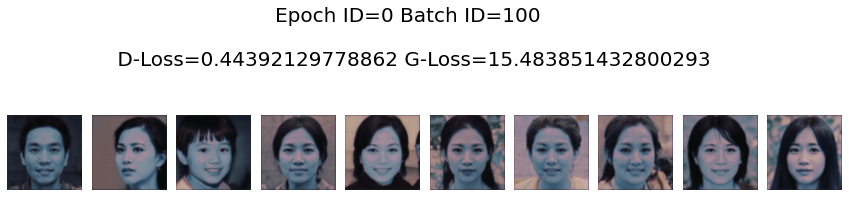

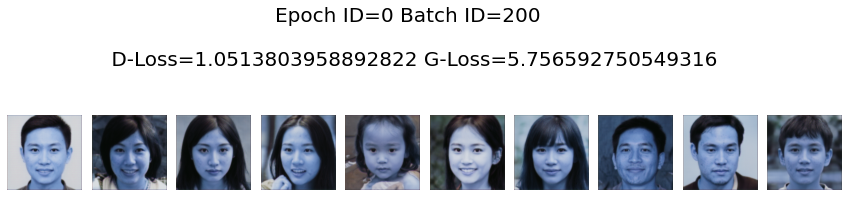

 now_step is: 300
Epoch ID=1 Batch ID=300 

 D-Loss=1.0663666725158691 G-Loss=4.608671188354492


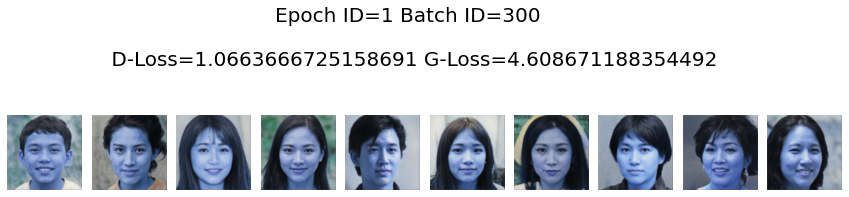

 now_step is: 400
Epoch ID=2 Batch ID=400 

 D-Loss=1.2101079225540161 G-Loss=3.5131516456604004


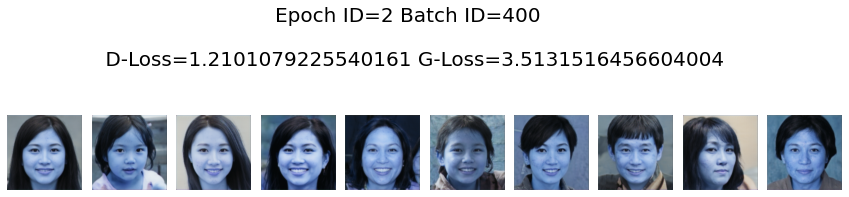

 now_step is: 500
Epoch ID=3 Batch ID=500 

 D-Loss=0.9373832941055298 G-Loss=5.457732200622559


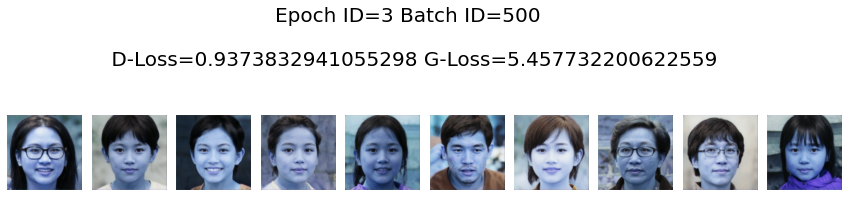

 now_step is: 600
Epoch ID=4 Batch ID=600 

 D-Loss=1.2824546098709106 G-Loss=3.657050609588623


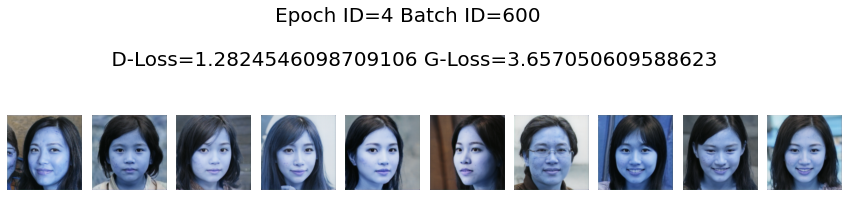

 now_step is: 700
Epoch ID=5 Batch ID=700 

 D-Loss=0.40090760588645935 G-Loss=5.6164350509643555


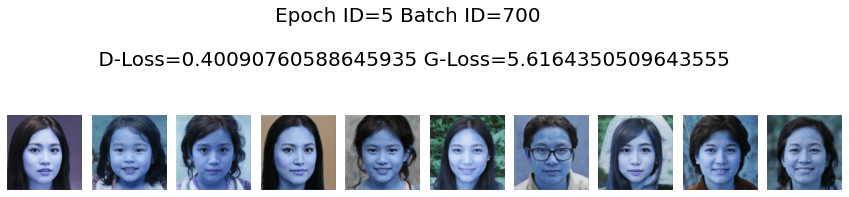

 now_step is: 800
Epoch ID=6 Batch ID=800 

 D-Loss=0.3961002230644226 G-Loss=5.374514102935791


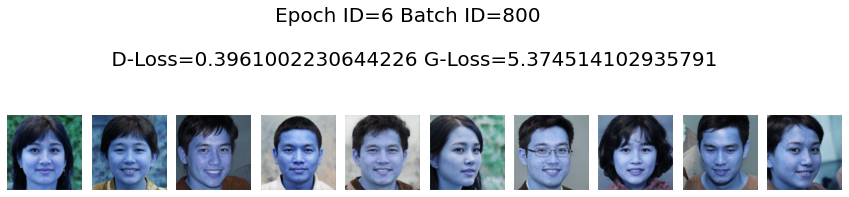

 now_step is: 900
Epoch ID=7 Batch ID=900 

 D-Loss=0.6395008563995361 G-Loss=3.664163589477539


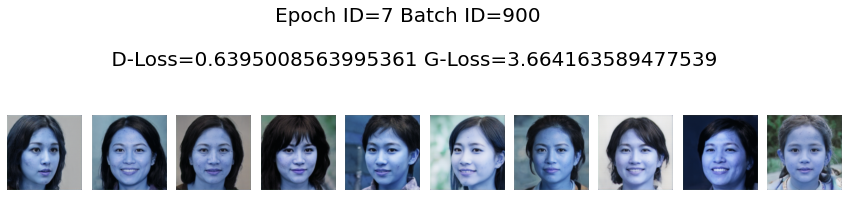

 now_step is: 931

KeyboardInterrupt: 

In [5]:
# create Net
netG = UnetGenerator()
netD = NLayerDiscriminator()

# 如果想要接着之前训练的模型训练，将if 0修改为if 1即可
if 0:
    try:
        mydict = paddle.load('generator.params')
        netG.set_dict(mydict)
        mydict = paddle.load('discriminator.params')
        netD.set_dict(mydict)
    except:
        print('fail to load model')

netG.train()
netD.train()
# optimizer配置
optimizerD = paddle.optimizer.Adam(parameters=netD.parameters(), learning_rate=0.00002, beta1=0.5, beta2=0.999)
optimizerG = paddle.optimizer.Adam(parameters=netG.parameters(), learning_rate=0.00002, beta1=0.5, beta2=0.999)

# Loss配置
bce_loss = paddle.nn.BCELoss()
l1_loss = paddle.nn.L1Loss()


# 最大迭代epoch
max_epoch = 240

now_step = 0
for epoch in range(max_epoch):
    for step, (img, mask) in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        # 清除D的梯度
        optimizerD.clear_grad()

        # 传入正样本，并更新梯度, 让判别器判断正样本是真的还是假的
        pos_img = paddle.concat((img, mask), 1) # img是没有痘痘的, mask是有痘痘的, 
        # label = paddle.full([pos_img.shape[0], 1], 1, dtype='float32') # 判别器判断出来的类别是什么
        pre = netD(pos_img)
        loss_D_1 = bce_loss(pre, paddle.ones_like(pre))
        loss_D_1.backward()

        # 通过randn构造随机数，制造负样本，并传入D，更新梯度
        fake_img = netG(mask).detach()
        neg_img = paddle.concat((fake_img, mask), 1)
        # label = paddle.full([pos_img.shape[0], 1], 0, dtype='float32')
        pre = netD(neg_img.detach()) # 通过detach阻断网络梯度传播，不影响G的梯度计算
        loss_D_2 = bce_loss(pre, paddle.zeros_like(pre))
        loss_D_2.backward()

        # 更新D网络参数
        optimizerD.step()
        optimizerD.clear_grad()

        loss_D = loss_D_1 + loss_D_2

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        # 清除D的梯度
        optimizerG.clear_grad()

        fake_img = netG(mask)
        fake = paddle.concat((fake_img, mask), 1)
        # label = paddle.full((pos_img.shape[0], 1), 1, dtype=np.float32,)
        output = netD(fake)
        loss_G_1 = l1_loss(fake_img, img) * 100.
        loss_G_2 = bce_loss(output, paddle.ones_like(pre))
        loss_G = loss_G_1+loss_G_2
        loss_G.backward()

        # 更新G网络参数
        optimizerG.step()
        optimizerG.clear_grad()

        now_step += 1

        print('\r now_step is:', now_step,end = '')
        ###########################
        # 可视化
        ###########################
        if now_step % 100 == 0:
            print()
            plt.figure(figsize=(15,15))
            try:
                for i in range(10):
                    # image = generated_image[i].transpose()
                    image = fake_img[i]
                    image = np.where(image > 0, image, 0)
                    image = image.transpose((1,2,0))
                    plt.subplot(10, 10, i + 1)
                    
                    plt.imshow(image)
                    plt.axis('off')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplots_adjust(wspace=0.1, hspace=0.1)
                msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(epoch, now_step, loss_D.numpy()[0], loss_G.numpy()[0])
                print(msg)
                plt.suptitle(msg,fontsize=20)
                plt.draw()
                # 保存在work文件夹下
                plt.savefig('{}/{:04d}_{:04d}.png'.format('work', epoch, now_step), bbox_inches='tight')
                plt.pause(0.01)
                break
            except IOError:
                print(IOError)
paddle.save(netG.state_dict(), "generator.params")
paddle.save(netD.state_dict(), "discriminator.params")
